In [1]:
import numpy as np
# import cv2
import tifffile as tiff
from shapely.geometry import Polygon, mapping, shape, box
from skimage import io
from skimage.measure import label, regionprops
import matplotlib.pyplot as plt
# import json
from rasterio import features
import scanpy as sc
import pandas as pd
import geopandas as gpd

import pickle
import scipy

import seaborn as sns

from SGanalysis.SGobject import SGobject

import matplotlib
%matplotlib inline
# matplotlib.use('Qt5Agg')
# %matplotlib qt

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import sys
import os

matplotlib.rcParams['pdf.fonttype'] = 42

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']

plt.rcParams['font.size'] = 6  # Set default font size for all text elements
plt.rcParams['axes.labelsize'] = 8  # Set font size for axis labels
plt.rcParams['xtick.labelsize'] = 6  # Set font size for x-axis tick labels
plt.rcParams['ytick.labelsize'] = 6  # Set font size for y-axis tick labels
plt.rcParams['legend.fontsize'] = 6  # Set font size for legend text


# tools_path  = '/Users/grantkinsler/Documents/Penn/Research/SpatialBarcodes/SpatialBarcodes/analysis/tools/tools.py'
tools_path = '../helperScripts/tools.py'
# tools_path  = '/Users/grantkinsler/Documents/Penn/Research/SpatialBarcodes/analysis/tools/tools.py'

# /Users/grantkinsler/Documents/Penn/Research/SpatialBarcodes/analysis/tools/tools.py
sys.path.append(os.path.dirname(os.path.expanduser(tools_path)))
import tools as tools

In [33]:
import pandas as pd
import pickle
import numpy as np

def merge_multiple_datasets(roi_list, tools, file_date='20240718'):
    """
    Merge multiple datasets while preserving unique object IDs and spatial locations.
    
    Parameters:
    roi_list: list of ROI identifiers
    tools: object containing roi_file_paths
    file_date: date string for file naming
    
    Returns:
    merged_df: combined dataframe with unique IDs
    merged_sg_obj: combined spatial graph object
    merged_sister_cells: combined sister cells dictionary
    """
    
    all_dfs = []
    all_sg_objs = []
    all_sister_cells = {}
    
    # Track global maximums to ensure unique IDs
    max_object_id = 0
    
    for roi_idx, roi_of_interest in enumerate(roi_list):
        print(f"Processing {roi_of_interest} (dataset {roi_idx + 1}/{len(roi_list)})")
        
        # Load the sg_object
        with open(f'{tools.roi_file_paths[roi_of_interest]["out_path"]}/sg_object_dilate10_{file_date}.pkl', 'rb') as f:
            sg_obj = pickle.load(f)
        
        # Load the dataframes
        unclustered_df = pd.read_csv(f'{tools.roi_file_paths[roi_of_interest]["out_path"]}/cell_by_gene_matrix_dilate10_{file_date}_withbarcodes_atleast3.csv')
        clustered_df = pd.read_csv(f'{tools.roi_file_paths[roi_of_interest]["out_path"]}/cell_by_gene_matrix_dilate10_{file_date}_withbarcodes_clustering_10bcs_0.2thresh.csv')
        
        # Create unique object IDs by adding offset
        original_object_ids = unclustered_df['object_id'].copy()
        unclustered_df['original_object_id'] = original_object_ids
        clustered_df['original_object_id'] = clustered_df['object_id'].copy()
        
        # Add offset to make IDs unique across datasets
        unclustered_df['object_id'] = unclustered_df['object_id'] + max_object_id
        clustered_df['object_id'] = clustered_df['object_id'] + max_object_id
        
        # Update max_object_id for next iteration
        max_object_id = unclustered_df['object_id'].max() + 1
        
        # Add dataset identifier
        unclustered_df['dataset'] = roi_of_interest
        clustered_df['dataset'] = roi_of_interest
        unclustered_df['dataset_idx'] = roi_idx
        clustered_df['dataset_idx'] = roi_idx
        
        # Merge clustered and unclustered dataframes
        cols_to_keep = ['object_id','bc_cluster','bc_cluster_n_bcs','bc_cluster_found_bcs','bc_cluster_bc_names']
        df = unclustered_df.merge(clustered_df[cols_to_keep], on='object_id', how='left')
        
        # Create cell_id
        df['cell_id'] = [f"{roi_of_interest}_{id}" for id in df['original_object_id']]
        
        # Process sg_obj with unique IDs
        # Handle both string and numeric indices
        if sg_obj.gdf.index.dtype == 'object' or sg_obj.gdf.index.dtype.kind in ['U', 'S']:
            # If index is string, create numeric mapping
            sg_obj.gdf['original_object_id'] = range(len(sg_obj.gdf))
            sg_obj.gdf['object_id'] = [i + (max_object_id - len(sg_obj.gdf)) for i in range(len(sg_obj.gdf))]
        else:
            # If index is numeric, use it directly
            sg_obj.gdf['original_object_id'] = sg_obj.gdf.index.copy()
            sg_obj.gdf['object_id'] = sg_obj.gdf.index + (max_object_id - len(sg_obj.gdf))
        
        sg_obj.gdf['cell_id'] = [f"{roi_of_interest}_{id}" for id in sg_obj.gdf['original_object_id']]
        sg_obj.gdf['dataset'] = roi_of_interest
        sg_obj.gdf['dataset_idx'] = roi_idx
        sg_obj.gdf.index.name = 'index'
        sg_obj.gdf = sg_obj.gdf.sort_values('object_id')
        
        # Add spatial offset to preserve physical separation (optional - adjust as needed)
        # This assumes you have x,y coordinates in sg_obj.gdf
        if 'x' in sg_obj.gdf.columns and 'y' in sg_obj.gdf.columns:
            # Add large offset to separate datasets spatially
            x_offset = roi_idx * 10000  # Adjust multiplier as needed
            y_offset = roi_idx * 10000  # Adjust multiplier as needed
            sg_obj.gdf['x'] = sg_obj.gdf['x'] + x_offset
            sg_obj.gdf['y'] = sg_obj.gdf['y'] + y_offset
            # Keep original coordinates for reference
            sg_obj.gdf['original_x'] = sg_obj.gdf['x'] - x_offset
            sg_obj.gdf['original_y'] = sg_obj.gdf['y'] - y_offset
        
        # Merge with df data
        merge_cols = ['cell_id'] + list(df.columns.difference(sg_obj.gdf.columns))
        sg_obj.gdf = sg_obj.gdf.merge(df[merge_cols], on=['cell_id'], how='left')
        
        # Create sister cells dictionary for this dataset
        cutoff = 3
        dataset_sister_cells = {}
        
        for bc_set in np.unique(df[df['n_called_barcodes']>=cutoff]['barcode_names'].values):
            if len(df[df['barcode_names']==bc_set]) >= 2:
                # Create unique barcode set name to avoid conflicts
                unique_bc_set = f"{roi_of_interest}_{bc_set}"
                dataset_sister_cells[unique_bc_set] = df[df['barcode_names']==bc_set].index
        
        # Store processed data
        all_dfs.append(df)
        all_sg_objs.append(sg_obj)
        all_sister_cells.update(dataset_sister_cells)
    
    # Combine all dataframes
    merged_df = pd.concat(all_dfs, ignore_index=True)
    
    # Combine all sg_obj.gdf DataFrames
    merged_gdf = pd.concat([sg_obj.gdf for sg_obj in all_sg_objs], ignore_index=True)
    
    # Create a merged sg_obj (using the first one as template)
    merged_sg_obj = all_sg_objs[0]  # Use first as template
    merged_sg_obj.gdf = merged_gdf
    
    print(f"\nMerging complete!")
    print(f"Total cells: {len(merged_df)}")
    print(f"Total datasets: {len(roi_list)}")
    print(f"Object ID range: {merged_df['object_id'].min()} - {merged_df['object_id'].max()}")
    print(f"Sister cell groups: {len(all_sister_cells)}")
    
    return merged_df, merged_sg_obj, all_sister_cells

# Usage example:
roi_list = ['dish_roi1','dish_roi2','dish_roi3']

# Call the function
merged_df, merged_sg_obj, merged_sister_cells = merge_multiple_datasets(roi_list, tools)

# Access your data as before, but now it's merged:
df = merged_df
sg_obj = merged_sg_obj
sister_cells = merged_sister_cells

# Optional: Save merged data
# merged_df.to_csv('merged_cell_by_gene_matrix.csv', index=False)
# with open('merged_sg_object.pkl', 'wb') as f:
#     pickle.dump(merged_sg_obj, f)

# Example analysis on merged data
print(f"\nDataset distribution:")
print(merged_df['dataset'].value_counts())

print(f"\nSample sister cell groups:")
for i, (bc_set, indices) in enumerate(list(merged_sister_cells.items())[:3]):
    print(f"  {bc_set}: {len(indices)} cells")

Processing dish_roi1 (dataset 1/3)
Processing dish_roi2 (dataset 2/3)


In [2]:
# roi_of_interest= 'dish_roi2'

# roi_list = ['dish_roi1','dish_roi2','dish_roi3']

# # load the sg_object
# with open(f'{tools.roi_file_paths[roi_of_interest]["out_path"]}/sg_object_dilate10_20240718.pkl', 'rb') as f:
#     sg_obj = pickle.load(f)

In [3]:
# # load the dataframes with the cell by gene matrices, clustered and unclustered
# unclustered_df =  pd.read_csv(f'{tools.roi_file_paths[roi_of_interest]["out_path"]}/cell_by_gene_matrix_dilate10_20240718_withbarcodes_atleast3.csv')
# clustered_df = pd.read_csv(f'{tools.roi_file_paths[roi_of_interest]["out_path"]}/cell_by_gene_matrix_dilate10_20240718_withbarcodes_clustering_10bcs_0.2thresh.csv')

In [4]:
# # merge the clustered and unclustered dataframes
# cols_to_keep = ['object_id','bc_cluster','bc_cluster_n_bcs','bc_cluster_found_bcs','bc_cluster_bc_names']
# df = unclustered_df.merge(clustered_df[cols_to_keep],on='object_id',how='left')   

In [5]:
# df['cell_id'] = [str(id) for id in df['object_id']]

# # sg_obj.gdf['cell_id'] = [str(x) for x in sg_obj.gdf['object_id']]
# sg_obj.gdf['object_id'] = sg_obj.gdf.index
# sg_obj.gdf['cell_id'] = sg_obj.gdf['object_id'].astype('string')
# sg_obj.gdf.index.name = 'index'
# sg_obj.gdf = sg_obj.gdf.sort_values('object_id')

# # assign clusters to the sg_obj
# sg_obj.gdf = sg_obj.gdf.merge(df[['cell_id']+list(df.columns.difference(sg_obj.gdf.columns))],on=['cell_id'],how='left')

In [7]:
# # create a dictionary of sister cells, including only those with more than 4 barcodes
# sister_cells = {}
# # cutoff = 4
# cutoff = 3

# for bc_set in np.unique(df[df['n_called_barcodes']>=cutoff]['barcode_names'].values):

#     # include clones with at least 2 cells
#     if len(df[df['barcode_names']==bc_set]) >= 2:

#         sister_cells[bc_set] = df[df['barcode_names']==bc_set].index

# # use clustered data 

# # for bc_set in np.unique(df[df['bc_cluster_n_bcs']>=cutoff]['bc_cluster'].values):

# #     # include clones with at least 2 cells
# #     if len(df[df['bc_cluster']==bc_set]) >= 2:

# #         sister_cells[bc_set] = df[df['bc_cluster']==bc_set].index

In [8]:
adata_genes = sc.AnnData(df[[col for col in tools.gene_cols if col in df.columns]])

/var/folders/x6/q0wb9df97nj1wnk5c4t0k7840000gn/T/ipykernel_31571/4178882684.py:1: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_genes = sc.AnnData(df[[col for col in tools.gene_cols if col in df.columns]])
/Users/grantkinsler/opt/miniconda3/envs/spatialgenomics-env2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [9]:
df[[col for col in tools.gene_cols if col in df.columns]]

,IGFBP2,IGFBP7,CAPG,SNAI2,VGF,MMP1,ITGA3,SERPINE1,COL1A1,CCND1,...,SOX9,ROR2,SLIT2,BMP4,FOSB,KIT,NOTCH4,DKK3,SOX2,NANOG
0,3.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5.0,0.0,13.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,12.0,0.0,16.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2.0,0.0,12.0,2.0,0.0,0.0,0.0,0.0,0.0,3.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,13.0,0.0,23.0,10.0,0.0,0.0,0.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16371,4.0,0.0,13.0,5.0,0.0,0.0,1.0,0.0,0.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16372,0.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16373,6.0,0.0,17.0,5.0,0.0,0.0,1.0,0.0,0.0,11.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16374,8.0,0.0,13.0,12.0,0.0,0.0,1.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
# log(x+1) transform the data
sc.pp.log1p(adata_genes)

In [11]:
adata_genes

AnnData object with n_obs × n_vars = 16376 × 117
    uns: 'log1p'

/Users/grantkinsler/opt/miniconda3/envs/spatialgenomics-env2/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


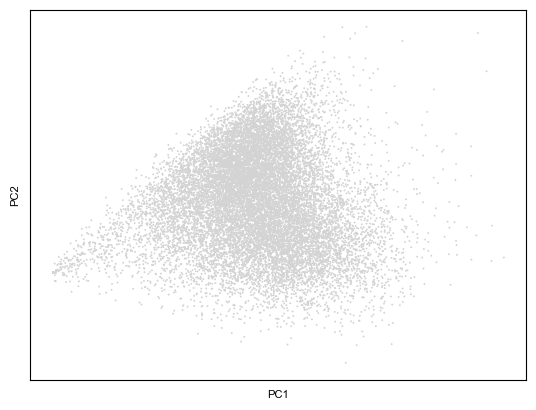

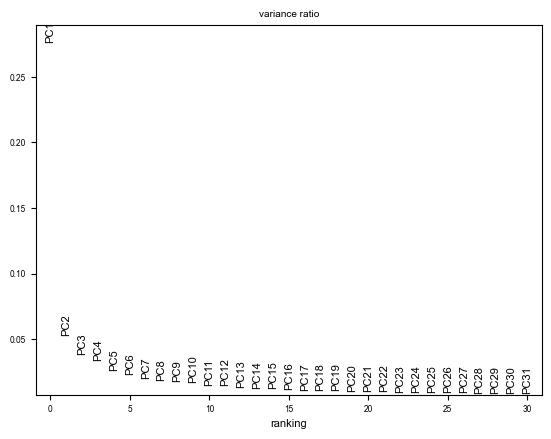

In [12]:
# perform and plot PCA 
sc.pp.pca(adata_genes)
sc.pl.pca(adata_genes)
sc.pl.pca_variance_ratio(adata_genes, log=False)

In [13]:
sc.pp.neighbors(adata_genes)

In [14]:
# perform leiden clustering
# sc.pp.scale(adata_genes)
sc.tl.umap(adata_genes)
sc.tl.leiden(adata_genes, n_iterations=-1)

/Users/grantkinsler/opt/miniconda3/envs/spatialgenomics-env2/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


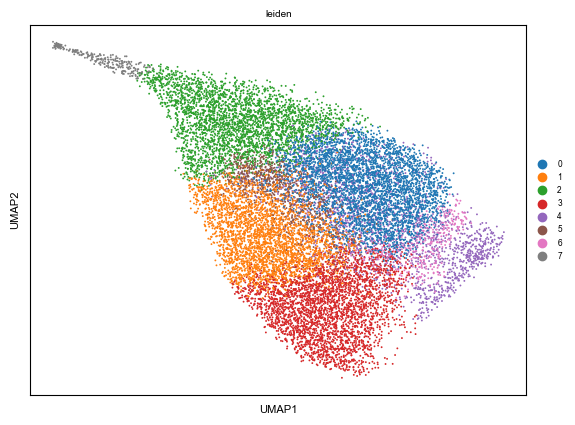

In [15]:
sc.pl.umap(adata_genes, color=["leiden"])

/Users/grantkinsler/opt/miniconda3/envs/spatialgenomics-env2/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


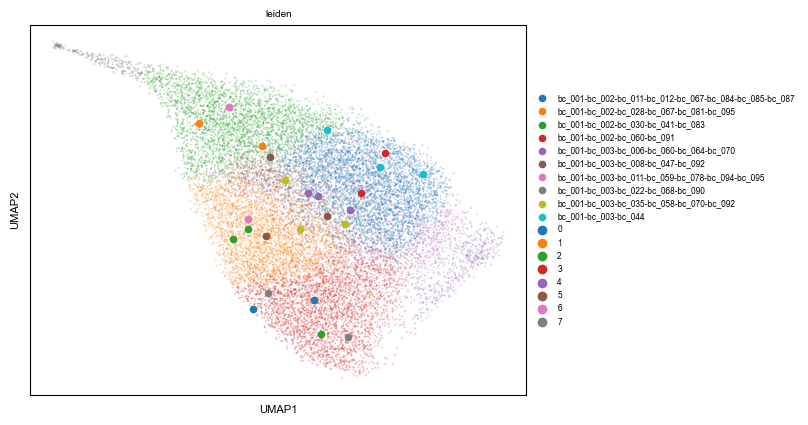

In [16]:
# plot sets of sisters on the UMAP

fig,ax = plt.subplots()
for b,(bc_set,ix) in enumerate(sister_cells.items()):
    if b < 10:
        umap_coords = adata_genes[ix].obsm['X_umap']
        ax.scatter(umap_coords[:,0],umap_coords[:,1],s=20,zorder=10,label=bc_set) 
sc.pl.umap(adata_genes, color=["leiden"],ax=ax,alpha=0.3)

 

In [17]:
# cells do appear to be closer in the umap, but let's also adjust for cell cycle:
cell_cycle_genes = tools.regev_cell_cycle_genes
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]
cell_cycle_genes = [x for x in cell_cycle_genes if x in adata_genes.var_names]

In [18]:
sc.tl.score_genes(adata_genes,cell_cycle_genes,score_name='g2m_score')

/Users/grantkinsler/opt/miniconda3/envs/spatialgenomics-env2/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


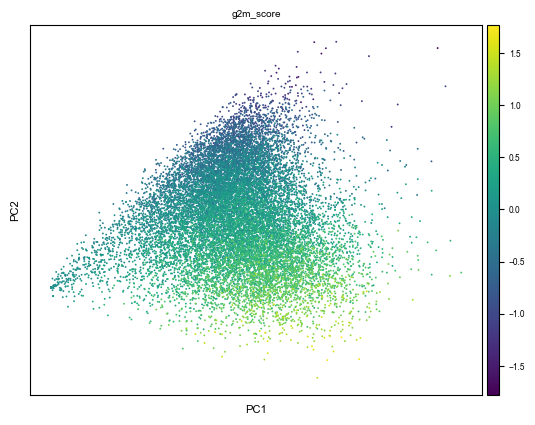

In [19]:
sc.pl.pca(adata_genes,color='g2m_score')

In [20]:
# # regress out the cell cycle score
# sc.pp.regress_out(adata_genes, ['g2m_score'])
# sc.pp.scale(adata_genes)
# perform new PCA with the regressed out data
# sc.pp.pca(adata_genes)
# sc.pl.pca(adata_genes)

/Users/grantkinsler/opt/miniconda3/envs/spatialgenomics-env2/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


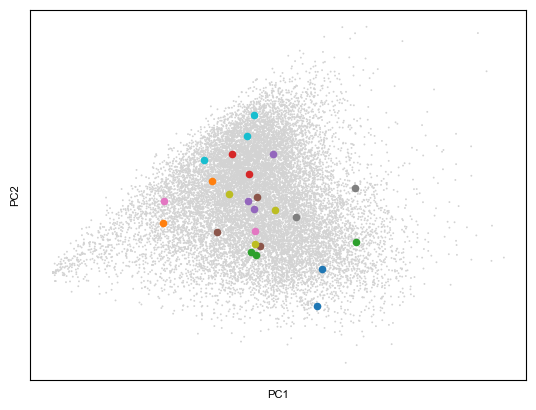

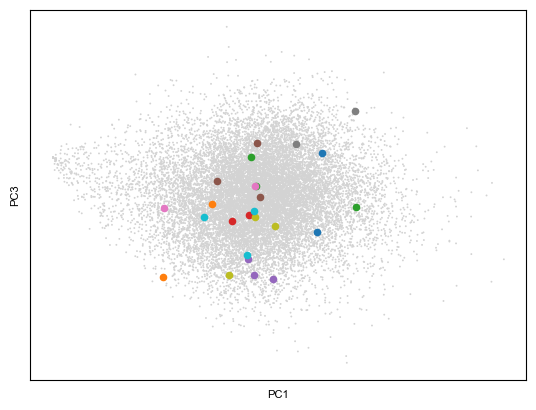

In [21]:
# perform PCA on the 

fig,ax = plt.subplots()
for b,(bc_set,ix) in enumerate(sister_cells.items()):
    if b < 10:
        pca_coords = adata_genes[ix].obsm['X_pca']
        ax.scatter(pca_coords[:,0],pca_coords[:,1],s=20,zorder=10,label=bc_set) 

sc.pl.pca(adata_genes,ax=ax,components='1,2')

fig,ax = plt.subplots()
for b,(bc_set,ix) in enumerate(sister_cells.items()):
    if b < 10:
        pca_coords = adata_genes[ix].obsm['X_pca']
        ax.scatter(pca_coords[:,0],pca_coords[:,2],s=20,zorder=10,label=bc_set) 

sc.pl.pca(adata_genes,ax=ax,components='1,3')
# ax.legend()
# fig.savefig('pca_sister_cells_G2Mregressed.pdf',bbox_inches='tight')
# fig.savefig('pca_sister_cells_G2Mregressed.png',dpi=300,bbox_inches='tight')

In [21]:
sister_cells_more = {}
for bc_set in np.unique(df[df['n_called_barcodes']>=4]['barcode_names'].values):
    if len(df[df['barcode_names']==bc_set]) > 1:

        sister_cells_more[bc_set] = df[df['barcode_names']==bc_set]['object_id'].values

# for bc_set in np.unique(df[df['bc_cluster_n_bcs']>=3]['bc_cluster'].values):
#     if len(df[df['bc_cluster']==bc_set]) > 1:

#         sister_cells_more[bc_set] = df[df['bc_cluster']==bc_set]['object_id'].values


sisterhood_by_cell_ix = {i:bc_set for bc_set,ix in sister_cells_more.items() for i in ix}
sister_ids_by_cell_ix = {i:list(sister_cells_more[bc_set]) for bc_set,ix in sister_cells_more.items() for i in ix}

In [22]:
# calculate the distance matrix of cells
centroid_array = np.stack(sg_obj.gdf['nucleus_centroid'].apply(lambda x: np.array(x.coords).ravel()))

distance_matrix = scipy.spatial.distance.pdist(centroid_array)
square_distance_matrix =scipy.spatial.distance.squareform(distance_matrix)

In [23]:
# get neighbors of a focal cell
def find_neighbors(ix,distance_matrix,threshold):
    # ix = df.index
    # this_ix = np.where(df['cell_id'] == cell_id)[0][0]

    # print(this_ix)
    neighbor_ix  = np.where(distance_matrix[ix,:] < threshold)[0]
    neighbor_ix = neighbor_ix[neighbor_ix != ix]    

    # neighbors = [x for x in df['cell_id'].values[neighbor_ix] if x !=cell_id]
     
    return neighbor_ix

# get non-sister neighbors of a focal cell
def find_non_sister_neighbors(ix,sisters,distance_matrix,threshold):
    neighbors = find_neighbors(ix,distance_matrix,threshold)
    non_sister_neighbors = [x for x in neighbors if x not in sisters]
    return non_sister_neighbors

# access by cell id
def find_neighbors_by_cell_id(cell_id,df,distance_matrix,threshold):
    # ix = df.index
    this_ix = np.where(df['cell_id'] == cell_id)[0][0]

    # print(this_ix)
    neighbor_ix  = np.where(distance_matrix[this_ix,:] < threshold)[0]

    neighbors = [x for x in df['cell_id'].values[neighbor_ix] if x!=cell_id]
     
    return neighbors




In [24]:
sister_more_dists = []
randos = []
neighbors= []
non_sister_neighbors = []

neighbor_distance = 1000

# all_ids = df.index
# all_ids = range(len(df))
all_ids = range(len(adata_genes))

pcs_to_use = 10

for b,(bc_set,ix) in enumerate(sister_cells_more.items()):

    # get the ix of the sister cells
    ix = np.where(df['object_id'].isin(list(ix)))[0]

    pca_coords = adata_genes[list(ix)].obsm['X_pca']

    d = scipy.spatial.distance.pdist(pca_coords[:,:pcs_to_use]) # calculate distance using top 20 PCs
    sister_more_dists.append(np.mean(d))

    pca_coords = adata_genes[np.random.choice(all_ids,len(ix))].obsm['X_pca']
    d = scipy.spatial.distance.pdist(pca_coords[:,:pcs_to_use]) # calculate distance using top 20 PCs
    randos.append(np.mean(d))

    random_cell = np.random.choice(all_ids,1)[0]
    these_neighbors = find_neighbors(random_cell,square_distance_matrix,neighbor_distance)
    pca_coords = adata_genes[np.random.choice(these_neighbors,len(ix))].obsm['X_pca']
    d = scipy.spatial.distance.pdist(pca_coords[:,:pcs_to_use]) # calculate distance using top 20 PCs
    neighbors.append(np.mean(d))

    # print('3')




Text(0.5, 0, 'Mean distance between sisters')

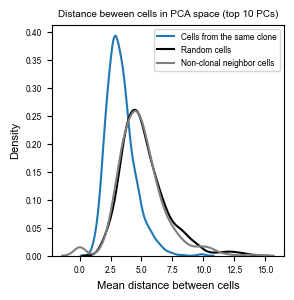

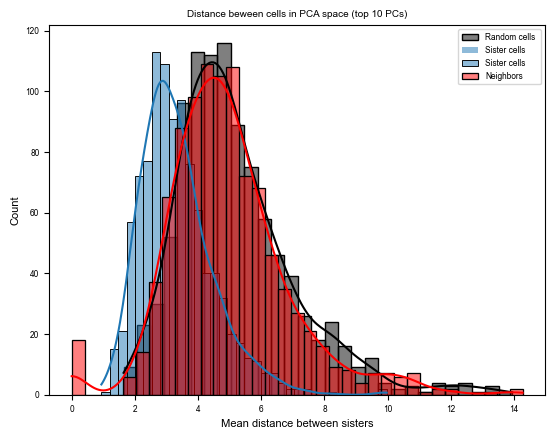

In [25]:
fig,ax = plt.subplots(figsize=(3,3))
sns.kdeplot(sister_more_dists,ax=ax,alpha=1.0,label='Cells from the same clone')
sns.kdeplot(randos,ax=ax,color='k',alpha=1.0,label='Random cells')
sns.kdeplot(neighbors,ax=ax,color='gray',alpha=1.0,label='Non-clonal neighbor cells')
# sns.histplot(neighbors,ax=ax,color='r',kde=True,alpha=0.5,label='Neighbors')
# sns.kdeplot(randos,ax=ax,color='gray',alpha=0.5)
# sns.kdeplot(sister_more_dists,ax=ax,alpha=0.5)
plt.legend()
plt.title(f'Distance beween cells in PCA space (top {pcs_to_use} PCs)')
plt.xlabel('Mean distance between cells')
# plt.savefig(f'../graphs/sister_cell_distances_withrandom_{pcs_to_use}PCs.pdf',bbox_inches='tight')

fig,ax = plt.subplots()
sns.histplot(randos,ax=ax,color='k',kde=True,alpha=0.5,label='Random cells ')
sns.histplot(sister_more_dists,ax=ax,kde=True,alpha=0.5,label='Sister cells')
sns.histplot(neighbors,ax=ax,color='r',kde=True,alpha=0.5,label='Neighbors')
# sns.kdeplot(randos,ax=ax,color='gray',alpha=0.5)
# sns.kdeplot(sister_more_dists,ax=ax,alpha=0.5)
plt.legend()
plt.title(f'Distance beween cells in PCA space (top {pcs_to_use} PCs)')
plt.xlabel('Mean distance between sisters')
# plt.savefig(f'sister_cell_distances_withrandom_{pcs_to_use}PCs.pdf',bbox_inches='tight')



In [26]:
sister_more_dists

[3.5312031293123654,
 3.75893115223693,
 4.184225743240425,
 2.311832169033237,
 2.2610133533691186,
 3.0217373080386722,
 5.158930387692724,
 3.4436930065812748,
 2.5614759217533387,
 4.946273455128905,
 5.018970164490185,
 2.998105571486746,
 4.501206883879451,
 3.2423466655227626,
 1.901582058174172,
 1.5187444057355652,
 2.7857304683285378,
 2.0573978687804644,
 2.425966559276589,
 5.582481959757883,
 2.757764243577466,
 2.6134625005296006,
 3.532554763497603,
 1.564178545881691,
 2.805951396973126,
 2.7611314947447863,
 2.4485359904981077,
 2.104082236752724,
 4.043961392214585,
 5.144281396900112,
 2.308083409303949,
 4.818274317793516,
 3.800741197174953,
 3.452564046550838,
 5.916907609997517,
 2.182782136071286,
 5.038706282841525,
 5.347260455085117,
 2.9607155521138115,
 2.185593099610385,
 3.4377769582386333,
 4.535182853047344,
 2.7420146112136834,
 2.984206163689475,
 3.656657465870651,
 4.130371379239648,
 2.4156324198960304,
 3.1939300439003246,
 7.241000001636721,
 4.6

In [27]:
print('Sister mean:'
      ,np.nanmean(sister_more_dists),
      'Random mean:',np.nanmean(randos),
        'Neighbors mean:',np.nanmean(neighbors))

print('T-test for difference in means between random and sister cells:')
print(scipy.stats.ttest_ind(randos,sister_more_dists))
print('')
print('T-test for difference in means between neighbor and sister cells:')
print(scipy.stats.ttest_ind(neighbors,sister_more_dists))

Sister mean: 3.322256563406698 Random mean: 5.19529207898227 Neighbors mean: 4.951146572226514
T-test for difference in means between random and sister cells:
Ttest_indResult(statistic=26.50704528357694, pvalue=1.010977130495886e-132)

T-test for difference in means between neighbor and sister cells:
Ttest_indResult(statistic=23.05184360216501, pvalue=2.493349481851412e-104)


In [28]:
sister_cells_more.items()

dict_items([('bc_001-bc_002-bc_011-bc_012-bc_067-bc_084-bc_085-bc_087', array([3826, 3940])), ('bc_001-bc_002-bc_028-bc_067-bc_081-bc_095', array([14314, 14336])), ('bc_001-bc_002-bc_030-bc_041-bc_083', array([8128, 8236, 8301])), ('bc_001-bc_002-bc_060-bc_091', array([7282, 7687])), ('bc_001-bc_003-bc_006-bc_060-bc_064-bc_070', array([10714, 10782, 11050])), ('bc_001-bc_003-bc_008-bc_047-bc_092', array([5232, 5290, 5681])), ('bc_001-bc_003-bc_011-bc_059-bc_078-bc_094-bc_095', array([15254, 15280])), ('bc_001-bc_003-bc_022-bc_068-bc_090', array([11344, 11380])), ('bc_001-bc_003-bc_035-bc_058-bc_070-bc_092', array([5145, 5170, 5261])), ('bc_001-bc_004-bc_005-bc_009-bc_038-bc_066', array([10179, 10208])), ('bc_001-bc_004-bc_009-bc_038-bc_066', array([10235, 10308])), ('bc_001-bc_004-bc_035-bc_041-bc_053-bc_062-bc_066', array([5600, 5648])), ('bc_001-bc_005-bc_010-bc_052-bc_064', array([2517, 2565])), ('bc_001-bc_005-bc_045-bc_057-bc_066-bc_076-bc_089', array([4623, 5226])), ('bc_001-bc_0

In [29]:
sister_more_dists = []
randos = []
neighbors= []
non_sister_neighbors = []

neighbor_distance = 1000

# all_ids = df.index
# all_ids = range(len(df))
all_ids = range(len(adata_genes))

np.random.seed(19104)

genes_to_use = ['IFIT2','OASL']

# gene_to_use = 'IFIT2'
# gene_to_use = 'OASL'
# gene_to_use = 'SFRP1'


sister_list = []
randos_list = []
neighbors_list = []


for b,(bc_set,ix) in enumerate(sister_cells_more.items()):

    if len(ix) > 2:
        ix = np.random.choice(ix,2)

    sister_list.append(df.loc[ix][gene].values)

    randos_list.append(df.loc[np.random.choice(all_ids,len(ix))][gene].values)

    # neighbors of any random cell
    # random_cell = np.random.choice(all_ids,1)[0]
    # these_neighbors = find_neighbors(random_cell,square_distance_matrix,neighbor_distance)
    # neighbors_list.append(df.loc[np.random.choice(these_neighbors,len(ix))][gene_to_use ].values)

    # actual neighbors of one of the sisters
    these_neighbors = find_neighbors(ix[0],square_distance_matrix,neighbor_distance)
    neighbors_list.append(df.loc[np.random.choice(these_neighbors,len(ix))][gene ].values)

for gene in genes_to_use:

    print(gene)



    cutoff = 1

    sister_df = pd.DataFrame()
    sister_df['sister_A'] = np.asarray(sister_list)[:,0] > cutoff
    sister_df['sister_B'] = np.asarray(sister_list)[:,1] > cutoff

    sister_crosstab = pd.crosstab(sister_df['sister_A'],sister_df['sister_B'])
    print('Sister')
    print(sister_crosstab)
    print('Fisher exact test:',scipy.stats.fisher_exact(sister_crosstab),'\n')

    randos_df = pd.DataFrame()
    randos_df['sister_A'] = np.asarray(randos_list)[:,0] > cutoff
    randos_df['sister_B'] = np.asarray(randos_list)[:,1] > cutoff

    randos_crosstab = pd.crosstab(randos_df['sister_A'],randos_df['sister_B'])
    print('Random')
    print(randos_crosstab)
    print('Fisher exact test:',scipy.stats.fisher_exact(randos_crosstab),'\n')

    neighbors_df = pd.DataFrame()
    neighbors_df['sister_A'] = np.asarray(neighbors_list)[:,0] > cutoff
    neighbors_df['sister_B'] = np.asarray(neighbors_list)[:,1] > cutoff

    neighbors_crosstab = pd.crosstab(neighbors_df['sister_A'],neighbors_df['sister_B'])

    print('Neighbors')
    print(neighbors_crosstab)
    print('Fisher exact test:',scipy.stats.fisher_exact(neighbors_crosstab),'\n')


# # convert into a two by two matrix for each pair of sisters as to whether they are both above the cutoff
# sisters_matrix = np.zeros((2,2))
# randos_matrix = np.zeros((2,2))



NameError: name 'gene' is not defined

In [ ]:
print(f'Number of sister pairs: {len(sister_list)}')

Number of sister pairs: 1528


In [30]:
import numpy as np
import pandas as pd
import scipy.stats

# Parameters
neighbor_distance = 1000
cutoff = 1
genes_to_use = ['IFIT2', 'OASL']
np.random.seed(19104)

# Generate the same groups of cells for all comparisons
all_ids = range(len(adata_genes))
sister_indices = []
random_indices = []
neighbor_indices = []

# Build consistent cell groups
for b, (bc_set, ix) in enumerate(sister_cells_more.items()):
    if len(ix) > 2:
        ix = np.random.choice(ix, 2, replace=False)
    
    sister_indices.append(ix)
    random_indices.append(np.random.choice(all_ids, len(ix), replace=False))
    
    # Get neighbors of the first sister cell
    these_neighbors = find_neighbors(ix[0], square_distance_matrix, neighbor_distance)
    neighbor_indices.append(np.random.choice(these_neighbors, len(ix), replace=False))

# Now test each gene using the same cell groups
results = {}

for gene in genes_to_use:
    print(f"=== Gene: {gene} ===")
    results[gene] = {}
    
    # Sister cells analysis
    sister_list = []
    for ix in sister_indices:
        sister_list.append(df.loc[ix][gene].values)
    
    sister_df = pd.DataFrame()
    sister_df['sister_A'] = np.asarray(sister_list)[:, 0] > cutoff
    sister_df['sister_B'] = np.asarray(sister_list)[:, 1] > cutoff
    sister_crosstab = pd.crosstab(sister_df['sister_A'], sister_df['sister_B'])
    
    print('Sister cells:')
    print(sister_crosstab)
    sister_fisher = scipy.stats.fisher_exact(sister_crosstab)
    print(f'Fisher exact test: odds ratio = {sister_fisher[0]:.4f}, p-value = {sister_fisher[1]:.4e}\n')
    results[gene]['sister'] = {'crosstab': sister_crosstab, 'fisher': sister_fisher}
    
    # Random pairs analysis
    random_list = []
    for ix in random_indices:
        random_list.append(df.loc[ix][gene].values)
    
    random_df = pd.DataFrame()
    random_df['cell_A'] = np.asarray(random_list)[:, 0] > cutoff
    random_df['cell_B'] = np.asarray(random_list)[:, 1] > cutoff
    random_crosstab = pd.crosstab(random_df['cell_A'], random_df['cell_B'])
    
    print('Random pairs:')
    print(random_crosstab)
    random_fisher = scipy.stats.fisher_exact(random_crosstab)
    print(f'Fisher exact test: odds ratio = {random_fisher[0]:.4f}, p-value = {random_fisher[1]:.4e}\n')
    results[gene]['random'] = {'crosstab': random_crosstab, 'fisher': random_fisher}
    
    # Neighbor pairs analysis
    neighbor_list = []
    for ix in neighbor_indices:
        neighbor_list.append(df.loc[ix][gene].values)
    
    neighbor_df = pd.DataFrame()
    neighbor_df['cell_A'] = np.asarray(neighbor_list)[:, 0] > cutoff
    neighbor_df['cell_B'] = np.asarray(neighbor_list)[:, 1] > cutoff
    neighbor_crosstab = pd.crosstab(neighbor_df['cell_A'], neighbor_df['cell_B'])
    
    print('Neighbor pairs:')
    print(neighbor_crosstab)
    neighbor_fisher = scipy.stats.fisher_exact(neighbor_crosstab)
    print(f'Fisher exact test: odds ratio = {neighbor_fisher[0]:.4f}, p-value = {neighbor_fisher[1]:.4e}\n')
    results[gene]['neighbor'] = {'crosstab': neighbor_crosstab, 'fisher': neighbor_fisher}
    
    print('-' * 50)

# Summary comparison
print("\n=== SUMMARY ===")
print("Gene\tGroup\t\tOdds Ratio\tp-value")
print("-" * 50)
for gene in genes_to_use:
    for group_type in ['sister', 'random', 'neighbor']:
        odds_ratio = results[gene][group_type]['fisher'][0]
        p_value = results[gene][group_type]['fisher'][1]
        print(f"{gene}\t{group_type.capitalize()}\t\t{odds_ratio:.4f}\t\t{p_value:.4e}")
    print()

=== Gene: IFIT2 ===
Sister cells:
sister_B  False  True 
sister_A              
False       979      5
True          5      0
Fisher exact test: odds ratio = 0.0000, p-value = 1.0000e+00

Random pairs:
cell_B  False  True 
cell_A              
False     978      5
True        6      0
Fisher exact test: odds ratio = 0.0000, p-value = 1.0000e+00

Neighbor pairs:
cell_B  False  True 
cell_A              
False     981      5
True        3      0
Fisher exact test: odds ratio = 0.0000, p-value = 1.0000e+00

--------------------------------------------------
=== Gene: OASL ===
Sister cells:
sister_B  False  True 
sister_A              
False       982      5
True          2      0
Fisher exact test: odds ratio = 0.0000, p-value = 1.0000e+00

Random pairs:
cell_B  False  True 
cell_A              
False     982      5
True        2      0
Fisher exact test: odds ratio = 0.0000, p-value = 1.0000e+00

Neighbor pairs:
cell_B  False  True 
cell_A              
False     979      5
True        5